In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for Neighbourhood-based Filtering
def find_source_region(image, mask_image,neighborhood_size,lower_limit,upper_limit):

    h, w = mask_image.shape[:2]
    result_image = image.copy()

    for i in range(h):
        for j in range(w):
            if mask_image[i, j] > 0:

                y_min = max(i - neighborhood_size, 0)
                y_max = min(i + neighborhood_size + 1, h)
                x_min = max(j - neighborhood_size, 0)
                x_max = min(j + neighborhood_size + 1, w)


                neighborhood = image[y_min:y_max, x_min:x_max]
                filtered_pixels = neighborhood[(neighborhood>lower_limit) & (neighborhood<upper_limit)]
                if len(filtered_pixels) > 0:
                    average_intensity = np.mean(filtered_pixels)
                    result_image[i, j]=average_intensity

    return result_image

# Function for Anisotropic Diffusion
def anisotropic_diffusion(image, mask, num_iter, kappa, gamma):

    image = np.float32(image)
    diffused_image = np.copy(image)

    for _ in range(num_iter):
        grad_x = np.diff(diffused_image, axis=1, append=diffused_image[:, -1:])
        grad_y = np.diff(diffused_image, axis=0, append=diffused_image[-1:, :])

        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        diff_coeff = np.exp(-(grad_mag / kappa)**2)

        diffused_image[1:, 1:] += gamma * (
            diff_coeff[:-1, :-1] * grad_x[:-1, :-1] +
            diff_coeff[:-1, 1:] * grad_x[:-1, 1:] +
            diff_coeff[:-1, :-1] * grad_y[:-1, :-1] +
            diff_coeff[1:, :-1] * grad_y[1:, :-1]
        )

    diffused_image = np.where(mask == 1, diffused_image, image)
    return diffused_image

# Reading input Image
image_directory = 'drive/MyDrive/Retinexformer-master/HaloDetected'
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.png'))]
if not image_files:
    print("No images found in the directory!")
    exit()
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('123.png', cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Image not found!")
        exit()

grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
magnitude = cv2.magnitude(grad_x, grad_y)
edges = cv2.convertScaleAbs(magnitude)

# Manual Thresholding
T_low = 140
T_high = 180
halo_mask = np.logical_and(image >= T_low, image <= T_high).astype(np.uint8)

plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.show()

plt.figure(figsize=(20, 20))
plt.imshow(halo_mask, cmap='gray')
plt.title('Halo Mask (Intensity 140-180)')
plt.axis('off')
plt.show()

diffused_image = anisotropic_diffusion(image,halo_mask, num_iter=50, kappa=40, gamma=0.05)

plt.figure(figsize=(20, 20))
plt.imshow(diffused_image, cmap='gray')
plt.title("Diffused Image")
plt.show()

result_image = find_source_region(diffused_image, halo_mask,70,90,180)
plt.figure(figsize=(10, 10))
plt.imshow(result_image, cmap='gray')
plt.title("Result Image")
plt.show()

_, mask = cv2.threshold(result_image, 180, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(20, 20))
plt.imshow(mask, cmap='gray')
plt.title("Mask Image")
plt.show()

new_result_image = find_source_region(result_image, mask,70,90,256)
plt.figure(figsize=(10, 10))
plt.imshow(new_result_image, cmap='gray')
plt.title("Final Enhanced Image")
plt.show()

In [ ]:
import math

def psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return 100  # Perfect match (no difference)
    max_pixel = 255.0
    return 20 * math.log10(max_pixel / math.sqrt(mse))

psnr_value = psnr(image, new_result_image)
print(f"PSNR: {psnr_value} dB")

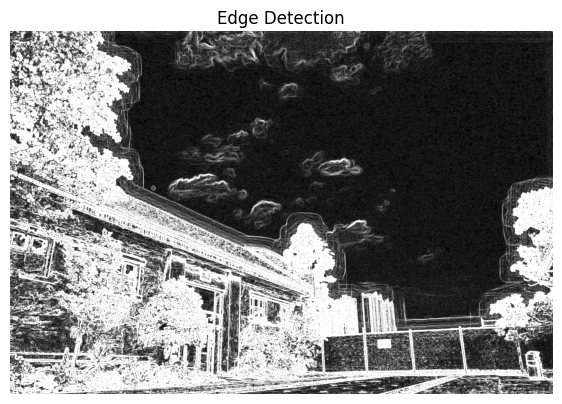

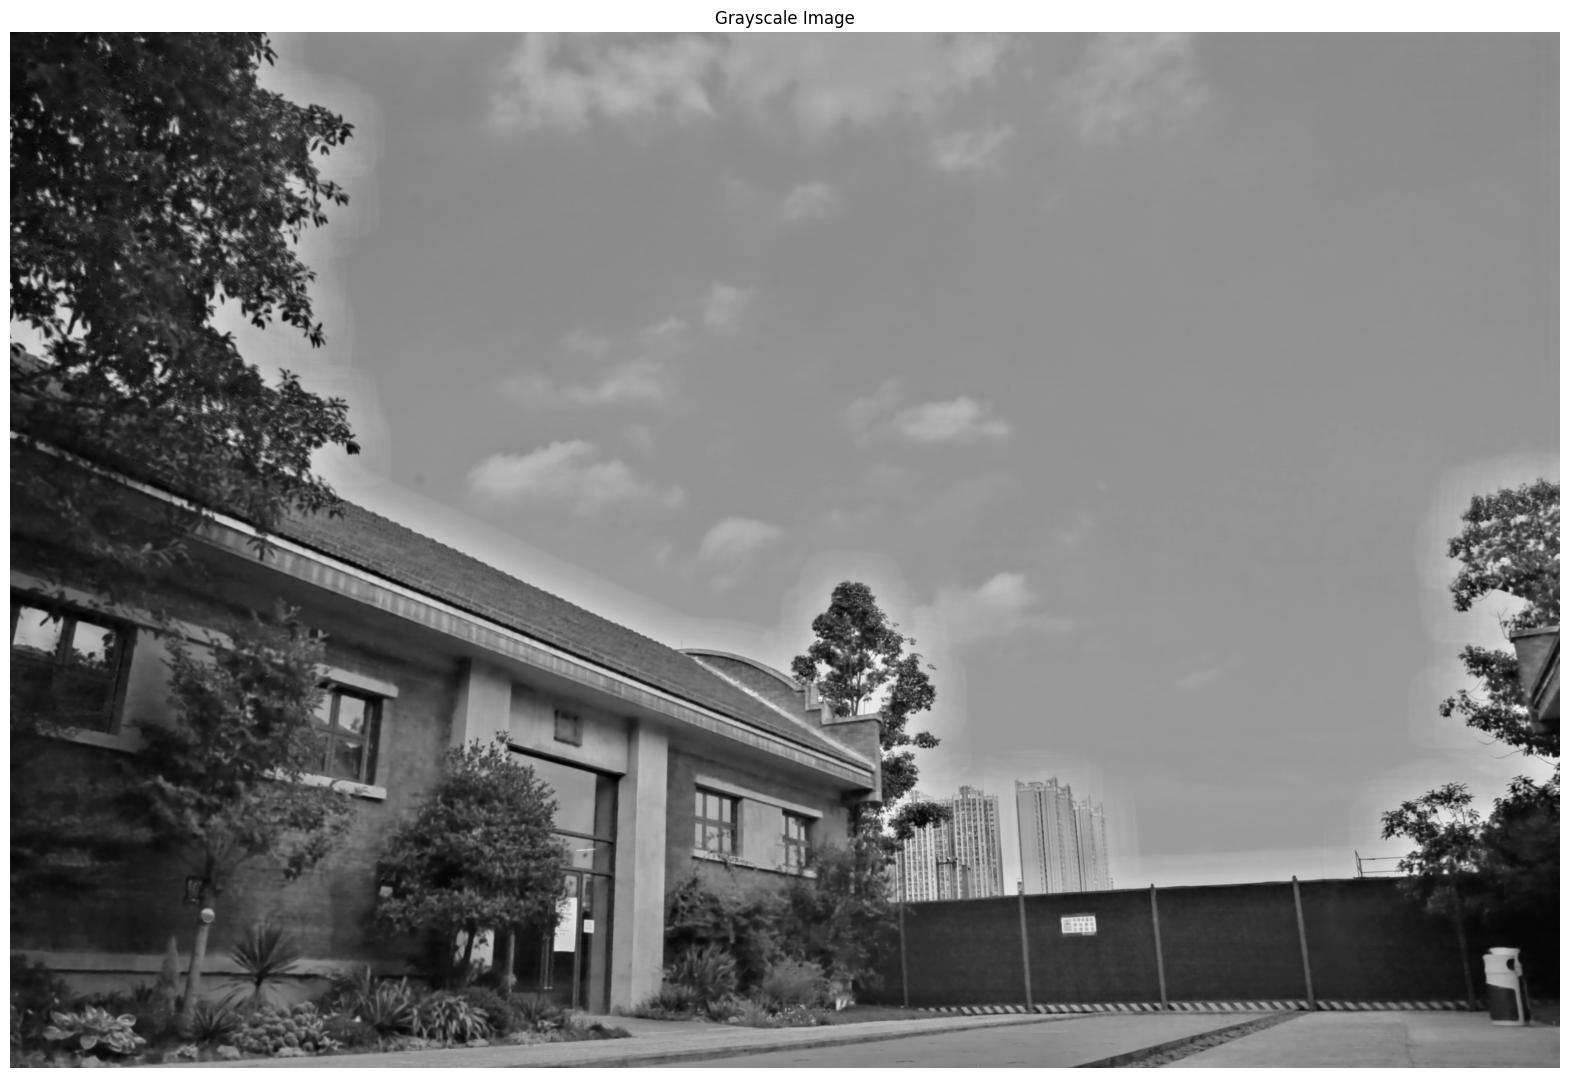

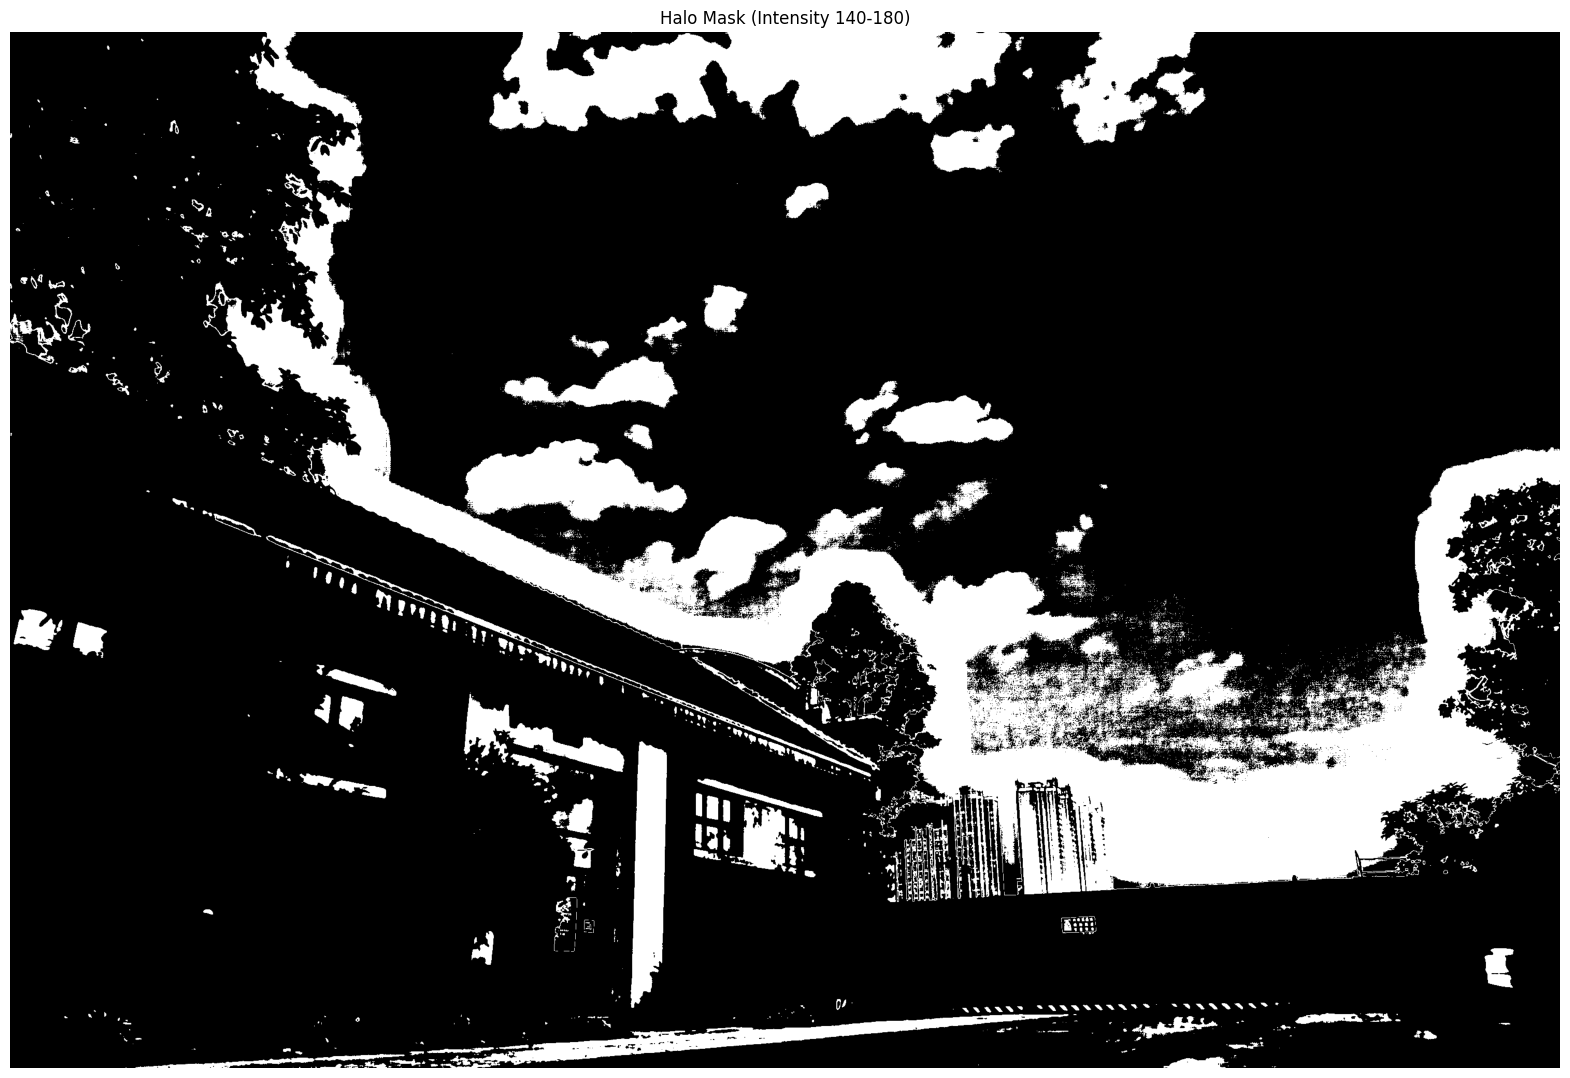

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for Neighbourhood-based Filtering
def find_source_region(image, mask_image,neighborhood_size,lower_limit,upper_limit):

    h, w = mask_image.shape[:2]
    result_image = image.copy()

    for i in range(h):
        for j in range(w):
            if mask_image[i, j] > 0:

                y_min = max(i - neighborhood_size, 0)
                y_max = min(i + neighborhood_size + 1, h)
                x_min = max(j - neighborhood_size, 0)
                x_max = min(j + neighborhood_size + 1, w)


                neighborhood = image[y_min:y_max, x_min:x_max]
                filtered_pixels = neighborhood[(neighborhood>lower_limit) & (neighborhood<upper_limit)]
                if len(filtered_pixels) > 0:
                    average_intensity = np.mean(filtered_pixels)
                    result_image[i, j]=average_intensity

    return result_image

# Reading input Image
image = cv2.imread('123.png', cv2.IMREAD_GRAYSCALE)
grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
magnitude = cv2.magnitude(grad_x, grad_y)
edges = cv2.convertScaleAbs(magnitude)

plt.figure(figsize=(7, 7))
plt.imshow(edges,cmap='gray')
plt.title('Edge Detection')
plt.axis('off')
plt.show()

# Manual Thresholding
T_low = 140
T_high = 180

halo_mask = np.logical_and(image >= T_low, image <= T_high).astype(np.uint8)

plt.figure(figsize=(20, 20))
plt.imshow(image,cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.figure(figsize=(20, 20))
plt.imshow(halo_mask, cmap='gray')
plt.title('Halo Mask (Intensity 140-180)')
plt.axis('off')
plt.show()

result_image = find_source_region(image, halo_mask,70,90,180)

plt.figure(figsize=(10, 10))
plt.imshow(result_image,cmap='gray')
plt.title('Result image')
plt.axis('off')
plt.show()
